In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### data loading

In [2]:
# walking 01
adj = torch.load('./data/adj01.pkl')
xs_wk = torch.load('./data/xs01.pkl')
# running 09 (share the same adj with walking dataset)
xs_ru = torch.load('./data/xs09.pkl')

xs_tr = torch.cat((xs_wk[:100],xs_ru[:100]),dim=0).float()
ys_tr = torch.cat((torch.ones(100),torch.zeros(100)),dim=0).long()

xs_te = torch.cat((xs_wk[100:130],xs_ru[100:130]),dim=0).float()
ys_te = torch.cat((torch.ones(30),torch.zeros(30)),dim=0).long()

In [3]:
xs_te.shape

torch.Size([60, 31, 3])

In [4]:
ys_te.shape

torch.Size([60])

In [5]:
#  adj to D^(-1/2)
def preprocess(A):
    # Get size of the adjacency matrix
    size = len(A)
    # Get the degrees for each node
    degrees = []
    for node_adjaceny in A:
        num = 0
        for node in node_adjaceny:
            if node == 1.0:
                num = num + 1
        # Add an extra for the "self loop"
        num = num + 1
        degrees.append(num)
    # Create diagonal matrix D from the degrees of the nodes
    D = np.diag(degrees)
    # Cholesky decomposition of D
    D = np.linalg.cholesky(D)
    # Inverse of the Cholesky decomposition of D
    D = np.linalg.inv(D)
    # Create an identity matrix of size x size
    I = np.eye(size)
    # Turn adjacency matrix into a numpy matrix
    A = np.matrix(A)
    # Create A hat
    A_hat = A + I
    # Return A_hat
    return A_hat, D

In [6]:
class GCN(nn.Module):
    """
    This is a simple case of GCN model
    This model is perpared for Motion Classification, thus it will be applied to the data
    with 31 nodes(joints), each node has information with 3 dimitions indicating the
    position of the node in 3D space
    This model has 3 layers to aggregate neighbors info
    After aggregation, we will cat node info together to predict the label of the body
    """
    def __init__(self):
        super(GCN, self).__init__()
        # layer
        self.l0 = nn.Linear(3,16,bias=False) #layer0
        self.l1 = nn.Linear(16,16,bias=False) #layer1
        self.out = nn.Linear(16,4) #output layer
        self.cl = nn.Linear(4*31,2)  #cat info of all nodes and predict the label of the body

    def forward(self,x,dad):
        #x: [batch,node,dim]
        #dad: [node,node]
        h0 = x
        dad = dad.unsqueeze(0).repeat(x.shape[0],1,1) #[node,node] => [batch,node,node]
        h1 = torch.relu(self.l0(dad.bmm(h0)))
        h2 = torch.relu(self.l1(dad.bmm(h1)))
        out = self.out(h2)
        out = out.view(h2.shape[0],-1)
        out = self.cl(out)
        return out

In [7]:
gcn = GCN()
lf = nn.CrossEntropyLoss() #loss function
op = optim.Adam(gcn.parameters(),lr=0.001)

### A to D^(-1/2)AD^(-1/2)

In [8]:
a,d = preprocess(adj)
a = torch.from_numpy(a)
d = torch.from_numpy(d)
dad = d.mm(a).mm(d).float()

## training

In [9]:
ls = []
ltes = []
for e in range(400):
    # train
    op.zero_grad()
    out = gcn(xs_tr,dad)
    loss = lf(out,ys_tr)
    loss.backward()
    ls.append(loss.item())
    op.step()
    # test
    out = gcn(xs_te,dad)
    lte = lf(out,ys_te)
    ltes.append(lte.item())

## plot the loss

In [10]:
import matplotlib.pyplot as plt

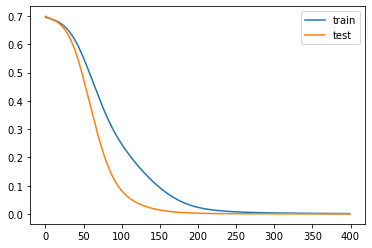

In [11]:
plt.plot(ls,label='train')
plt.plot(ltes,label='test')
plt.legend()
plt.show()

In [12]:
te = gcn(xs_te[-3:],dad)

In [13]:
softmax_func=nn.Softmax(dim=1)
so=softmax_func(te)